[Link to colab](https://colab.research.google.com/github/lsmin0152/cheb301/blob/main/notebooks/CHEB301_F25_15_DT_and_RF.ipynb)

## **Decision Trees**
Machine learning with decision trees is another very popular approach. You are already likely familiar with the concept of decision trees/flow charts for navigating some process and taking actions according to specific outcomes. Decision trees are functionally very similar. One advantage of decision trees is that they are relatively transparent, such that the results are discernible by human inspection. In a decision tree, the leaves provide labels while the branches are combinations of features that lead such labels.

The cells below will explore the implementation of decision trees for classification.

### 1. Gini Impurity

The Gini impurity is a measure that determines how information flows/is split at a given node on the tree. This is functionally related to the likelihood of random data being misclassified by chance according to the population of possible labels. When certain features possess low impurity, they are good at correctly splitting the data. High impurities (-->0.5) suggest that the information content is low on that feature.

In [1]:
# modules needed for this notebook
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [2]:
def gini_impurity(y):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    probabilities = label_counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def weighted_gini_impurity(y_left, y_right):
    left_size = len(y_left)
    right_size = len(y_right)
    total_size = left_size + right_size
    weighted_gini = (left_size / total_size) * gini_impurity(y_left) + (right_size / total_size) * gini_impurity(y_right)
    return weighted_gini

y_left = np.array([1, 0, 1, 1, 1, 0])
y_right = np.array([0, 0, 0, 1])

print(f"Gini impurity of left node: {gini_impurity(y_left):.4f}")
print(f"Gini impurity of right node: {gini_impurity(y_right):.4f}")
print(f"Weighted Gini impurity of split: {weighted_gini_impurity(y_left, y_right):.4f}")

Gini impurity of left node: 0.4444
Gini impurity of right node: 0.3750
Weighted Gini impurity of split: 0.4167


### 2. Entropy

Entropy is another useful measure of node impurity. In addition the probability of variables, it will also depend on the number of variables. This measure  can be related to information gain by comparisons before/after nodes. You may choose to split by either entropy or gini impurity -- this is a hyperparameter choice.


In [3]:
def entropy(y):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    probabilities = label_counts / len(y)
    H = - np.sum(probabilities * np.log2(probabilities))
    return H

def weighted_entropy(y_left, y_right):
    left_size = len(y_left)
    right_size = len(y_right)
    total_size = left_size + right_size
    weighted_entropy = (left_size / total_size) * entropy(y_left) + (right_size / total_size) * entropy(y_right)
    return weighted_entropy

y_left = np.array([1, 0, 1, 1, 1, 0])
y_right = np.array([0, 0, 0, 1])

print(f"Entropy of left node: {entropy(y_left):.4f}")
print(f"Entropy of right node: {entropy(y_right):.4f}")
print(f"Weighted entropy of split: {weighted_entropy(y_left, y_right):.4f}")

Entropy of left node: 0.9183
Entropy of right node: 0.8113
Weighted entropy of split: 0.8755


### 3. Simple Decision Tree

So, let's look at the implementation and differences between splitting criterion. As you will also see, we can scrutinize the tree to gain insight into the decision-making process.

In [4]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# train the decision tree classifier
tree_classifier = DecisionTreeClassifier(criterion="gini", random_state=42)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


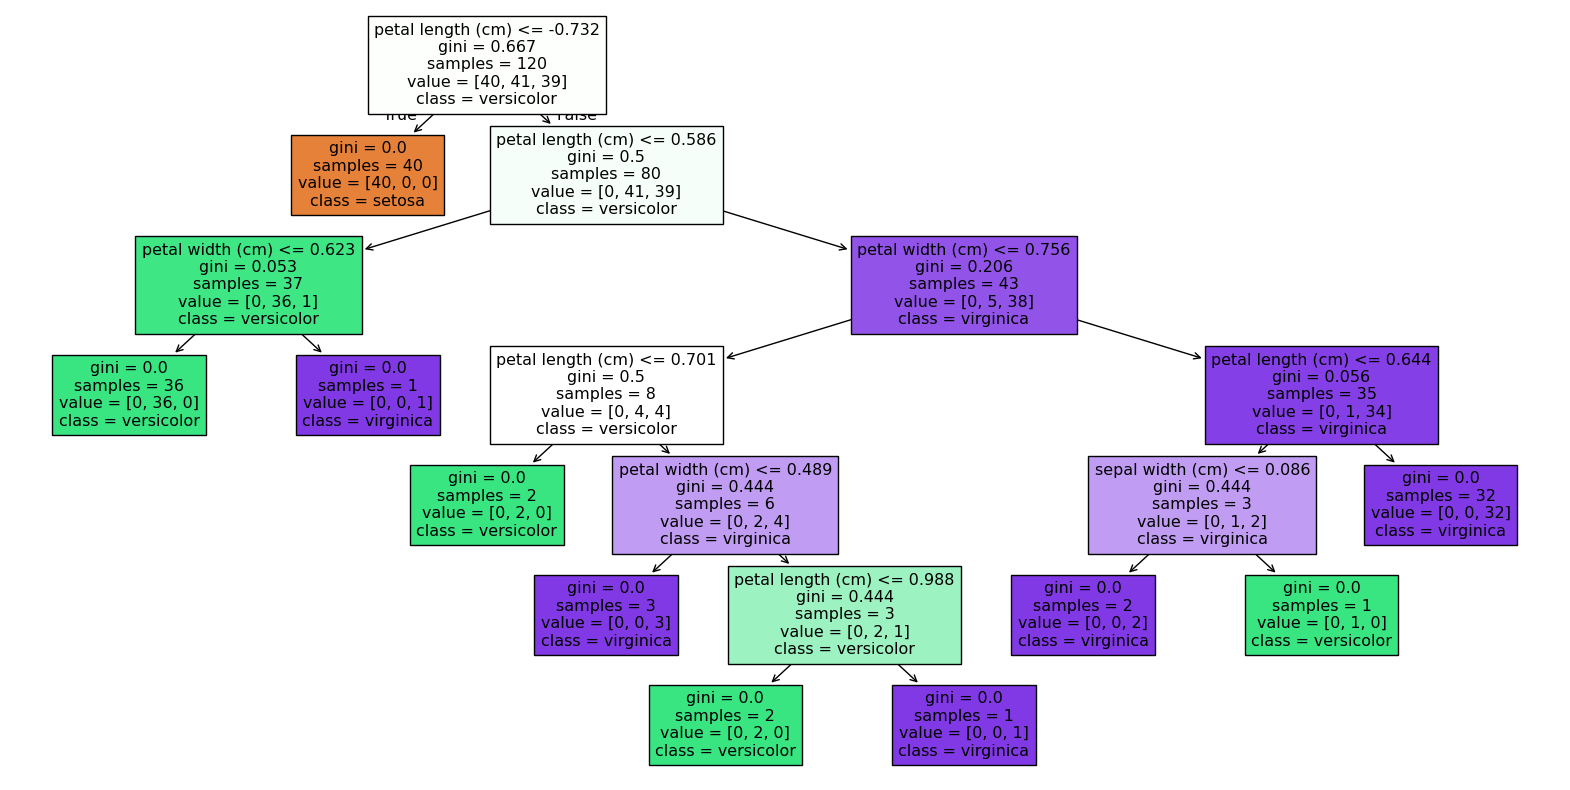

In [6]:
# visualize the trained decision tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(tree_classifier, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show();

In [7]:
# show the tree rules
tree_rules = export_text(tree_classifier, feature_names=iris.feature_names)
print("Decision Tree Rules:\n", tree_rules)

Decision Tree Rules:
 |--- petal length (cm) <= -0.73
|   |--- class: 0
|--- petal length (cm) >  -0.73
|   |--- petal length (cm) <= 0.59
|   |   |--- petal width (cm) <= 0.62
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.62
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.59
|   |   |--- petal width (cm) <= 0.76
|   |   |   |--- petal length (cm) <= 0.70
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  0.70
|   |   |   |   |--- petal width (cm) <= 0.49
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  0.49
|   |   |   |   |   |--- petal length (cm) <= 0.99
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  0.99
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  0.76
|   |   |   |--- petal length (cm) <= 0.64
|   |   |   |   |--- sepal width (cm) <= 0.09
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  0.09
|   |   |   |   |   |--- class: 1

### 4. Decision Tree Hyperparameter Tuning

In [8]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# define the model
model = DecisionTreeClassifier(random_state=42)

# define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
    param_criterion param_max_depth  param_min_samples_split  \
0              gini            None                        2   
1              gini            None                        5   
2              gini            None                       10   
3              gini            None                        2   
4              gini            None                        5   
..              ...             ...                      ...   
103         entropy              50                        5   
104         entropy              50                       10   
105         entropy              50                        2   
106         entropy              50                        5   
107         entropy              50                       10   

     param_min_samples_leaf  mean_test_score  
0                         1         0.950000  
1                         1         0.933333  
2                         1        

# Random Forest

Random forest algorithms are based on decision trees. The underlying principle here is to use the concept of *ensemble learning*, in effect having many decision trees to help make prediction on labels. This generally mitigates overfitting that may befall a single decision tree and is just overall a superior strategy.

### 1. Simple Random Forest

Below, we will see how to implement random forest. It's so easy! We need to specify the number of estimators now as a hyperparameter.

In [10]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# train the random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=42)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


### 2. Feature Importance

Because of their relationship to decision trees, it is also straightforward to interrogate the decisions of the forest and ascertain what features were most critical/influential.

In [14]:
importances = forest_clf.feature_importances_

for feature, importance in zip(iris.feature_names, importances):
    print(f"{feature}: {importance:0.4f}")

sepal length (cm): 0.1081
sepal width (cm): 0.0304
petal length (cm): 0.4400
petal width (cm): 0.4215


### 3. Hyperparameter Tuning

In [13]:
# define the model
model = RandomForestClassifier(random_state=42)

# define the hyperparameters to tune
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=100,
                                 scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_n_estimators', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
    param_n_estimators param_criterion param_max_depth  \
0                   20            gini              30   
1                   40            gini            None   
2                   40         entropy              10   
3                   40         entropy              30   
4                   40            gini              20   
..                 ...             ...             ...   
95                 100            gini              10   
96                  20            gini              20   
97                  60         entropy              30   
98                  40            gini              10   
99                 100         entropy              20   

    param_min_samples_split  param_min_samples_leaf  mean_test_score  
0                         2                       1         0.950000  
1                        10                       1         0.958333  
2                         5        